In [2]:
import os
import sys
import torch
import numpy as np
from tqdm import tqdm
from util import get_transforms, get_dataset, get_image_size, get_dataloader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
%reload_ext autoreload
%autoreload 2



dataset_name = 'MNIST'
batch_size = 1  # record each loss element, not mean
timesteps = 300

image_size = get_image_size(dataset_name)
transform, _ = get_transforms(image_size=image_size)
trainset, testset = get_dataset(dataset_name, transform)
trainloader, testloader = get_dataloader(trainset, testset, 1)


In [3]:
record_latent_features = torch.load('./weight/record_latent_features.pt')
record_latent_features_loss = torch.load('./weight/record_latent_features_loss.pt')

In [4]:
def flatten_features(record_latent_Features):
    for key in record_latent_Features.keys():
        for i in range(len(record_latent_Features[key])):
            record_latent_Features[key][i] = record_latent_Features[key][i].flatten()

def calc_avg_distance(record_latent_features):

    record_feature_dist = {}
    record_feature_stats = {}

    tqdmr = tqdm(record_latent_features.keys(), desc='calculate the stats of latent features for training samples')

    for key  in tqdmr:

        rand_ids = np.random.choice(len(record_latent_features[key]), size=30000, replace=False)
        vectors = np.array(record_latent_features[key])[rand_ids,:]
        
        # Compute squared distances
        dot_product = np.dot(vectors, vectors.T)
        squared_norms = np.sum(vectors**2, axis=1, keepdims=True)
        squared_distances = squared_norms + squared_norms.T - 2 * dot_product
        
        # Ensure distances are non-negative
        squared_distances = np.maximum(squared_distances, 0)
        
        # Take the square root to get L2 distance
        distances = np.sqrt(squared_distances)

        record_feature_dist[key] = distances
        record_feature_stats[key] = (np.mean(distances), np.std(distances))
    
    return record_feature_dist, record_feature_stats

class pca_ood_detector:
    def __init__(self, record_latent_features):
        self.record_latent_features = record_latent_features

    def pca_analyze(self):
        ...

    def calc_l2_distance(self, latent):
        ...


# average distance

In [42]:
flatten_features(record_latent_features)

In [6]:
record_feature_dist, record_feature_stats = calc_avg_distance(record_latent_features)

calculate the stats of latent features for training samples: 100%|██████████| 4/4 [01:30<00:00, 22.58s/it]


In [6]:
[len(record_latent_features[key]) for key in record_latent_features.keys()]

[59968, 59968, 59968, 59968]

In [6]:
tmp = np.array(record_latent_features[5])

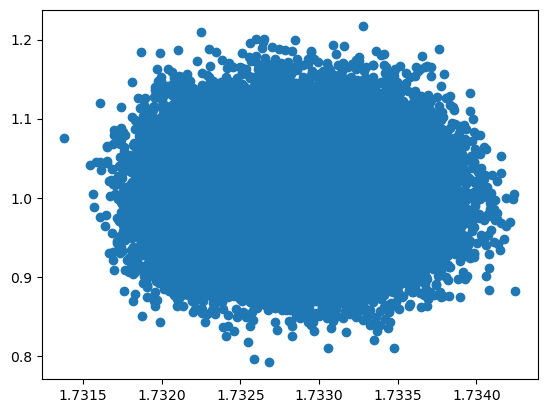

In [12]:
plt.scatter(np.linalg.norm(tmp,axis=1),record_latent_features_loss[100])

In [13]:
trainset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

# TSNE dimension reduction

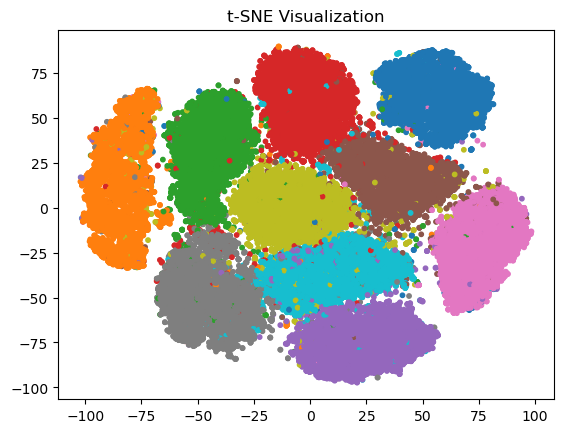

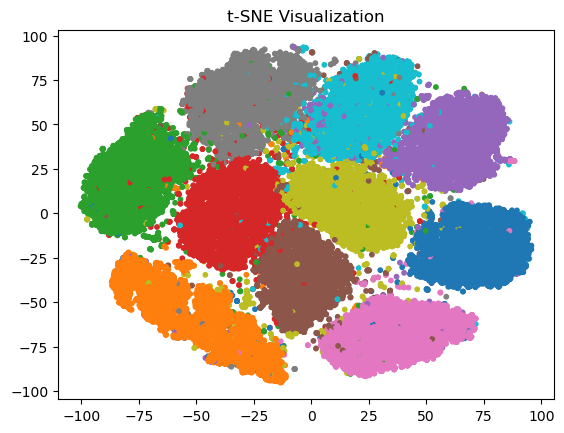

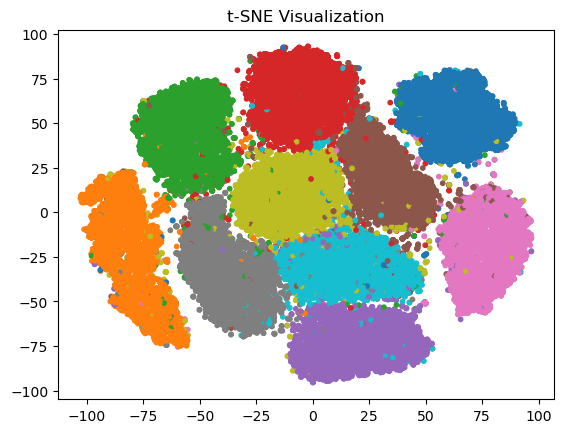

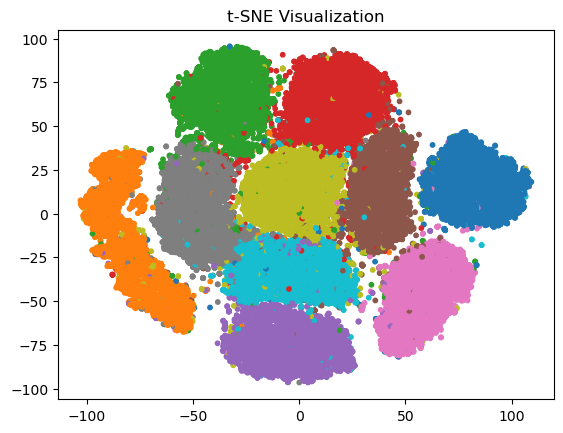

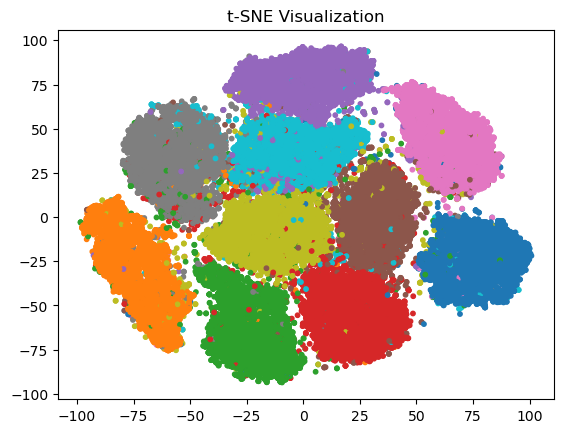

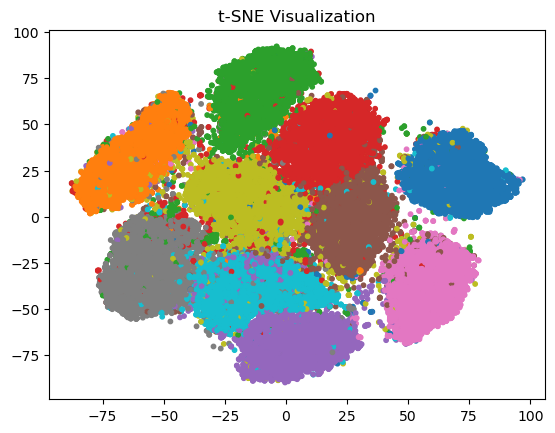

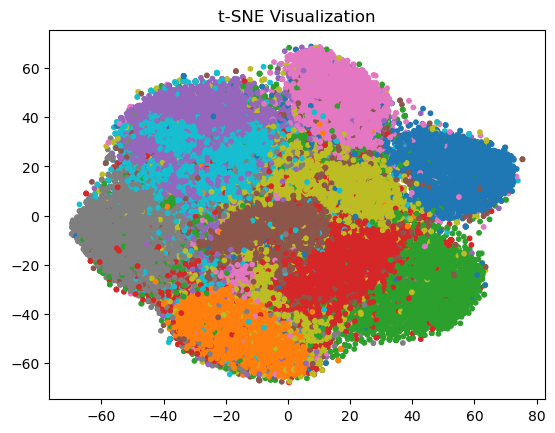

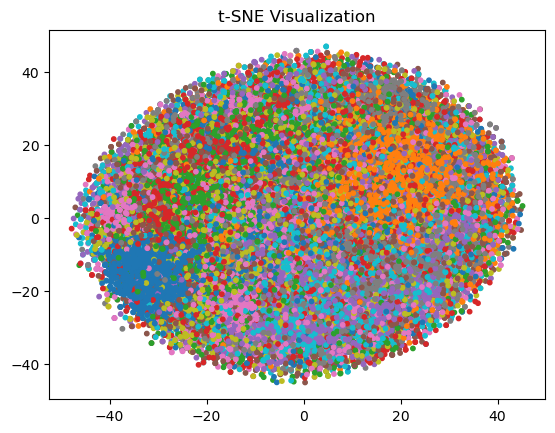

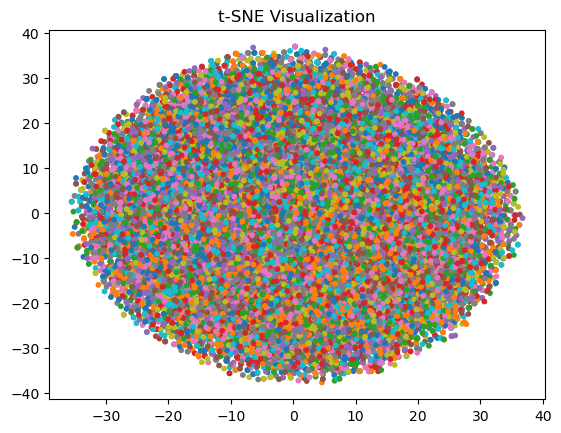

In [43]:
for key in record_latent_features.keys():
    tmp = np.array(record_latent_features[key])

    # Instantiate the t-SNE model
    tsne = TSNE(n_components=2, random_state=42)

    # Fit the model and transform the data to the 2D space
    matrix_embedded = tsne.fit_transform(tmp)

    # Plot the results
    # plt.scatter(matrix_embedded[:, 0], matrix_embedded[:, 1])
    scatter = plt.scatter(matrix_embedded[:, 0], matrix_embedded[:, 1], c=trainset.targets, cmap='tab10', s=10)
    plt.title('t-SNE Visualization')
    plt.show()

    (0,1,5,10,25,50,100,200,299)

# ood detector

In [5]:
class pca_ood_detector:
    def __init__(self, record_latent_features):
        
        self.record_latent_features = record_latent_features
        self.timesteps = self.record_latent_features.keys()
        flatten_features(self.record_latent_features)

    def pca_analyze(self):

        self.pca_models = { key:None for key in self.record_latent_features.keys() }
        self.pca_projected_latents = { key:None for key in self.record_latent_features.keys() }
        tqmdr = tqdm(self.record_latent_features.keys(), desc='pca_analysis')
        
        for key in tqmdr:
            pca_model = PCA(n_components='mle')
            res = pca_model.fit_transform(self.record_latent_features[key])
            self.pca_models[key] = pca_model
            self.pca_projected_latents[key] = res

    def calc_avg_distance(self):    # setting threshold

        pca_projected_latents_dist = {}
        pca_projected_latents_stats = {}

        tqdmr = tqdm(self.pca_projected_latents.keys(), desc='calculate the stats of latent features for training samples')

        for key  in tqdmr:

            rand_ids = np.random.choice(len(self.pca_projected_latents[key]), size=10000, replace=False)
            vectors = np.array(self.pca_projected_latents[key])[rand_ids,:]
            
            # Compute squared distances
            dot_product = np.dot(vectors, vectors.T)
            squared_norms = np.sum(vectors**2, axis=1, keepdims=True)
            squared_distances = squared_norms + squared_norms.T - 2 * dot_product
            
            # Ensure distances are non-negative
            squared_distances = np.maximum(squared_distances, 0)
            
            # Take the square root to get L2 distance
            distances = np.sqrt(squared_distances)

            pca_projected_latents_dist[key] = distances
            pca_projected_latents_stats[key] = (np.mean(distances), np.std(distances))

        self.pca_projected_latents_dist = pca_projected_latents_dist
        self.pca_projected_latents_stats = pca_projected_latents_stats

    def set_threshold(self, sigma_threshold=5): # mean+3*std

        self.thresholds = { key:self.pca_projected_latents_stats[key][0]+sigma_threshold*self.pca_projected_latents_stats[key][1] 
                          for key in self.pca_projected_latents_stats.keys() }

    def detect_l2_distance_ood(self, latent, timestep):
        assert timestep in self.timesteps 
        projected_latent = self.pca_models[timestep].transform(latent)
        l2_distances = np.linalg.norm(self.pca_projected_latents[timestep] - projected_latent, axis=1)
        min_distance = np.min(l2_distances)
        if min_distance > self.thresholds[timestep]:
            print('ood sample!')
            return True, min_distance
        else:
            return False, min_distance


In [6]:
detector = pca_ood_detector(record_latent_features)
detector.pca_analyze()

pca_analysis: 100%|██████████| 9/9 [02:35<00:00, 17.25s/it]


In [7]:
detector.calc_avg_distance()

calculate the stats of latent features for training samples:   0%|          | 0/9 [00:00<?, ?it/s]

calculate the stats of latent features for training samples: 100%|██████████| 9/9 [00:11<00:00,  1.31s/it]


In [8]:
detector.set_threshold(3)

In [9]:
detector.pca_projected_latents[1].shape

(59904, 493)

In [32]:
import wandb
import torch
import argparse
import torchvision
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from unet import UNet
from model import DiffusionModel
from util import get_transforms, get_dataset, get_image_size, get_dataloader
import sys

def infer(unet, diffusion_model, device, T, reverse_transform, n):

    unet.train()
    sd = []
    total_samples = []
    with torch.no_grad():
        for _ in range(n):
            samples = []
            image = torch.randn((64, 1, 28, 28)).to(device)
            for i in reversed(range(diffusion_model.timesteps)):
                samples_at_step = []
                for _ in range(T):
                    image = diffusion_model.backward(image, torch.full((1, ), i, dtype=torch.long, device=device), unet)
                    samples_at_step.append(image)
                samples_at_step = torch.cat(samples_at_step, dim=0)
                mean_sample = samples_at_step.mean(dim=0)
                sd_sample = samples_at_step.std(dim=0).mean()
                if i % 50 == 0:
                    samples.append(reverse_transform(mean_sample).cpu())
            sd.append(sd_sample.cpu().item())
            total_samples.append(samples)
    return total_samples, sd

def infer_ood(unet, diffusion_model, ood_detector, device, reverse_transform, n_imgs):

    unet.eval()
    unet._start_ood_detection(ood_detector, (0,1,5,10,25,50,100,200,299))
    
    infer_samples = []
    with torch.no_grad():
        tqdmr = tqdm(range(n_imgs))
        for _ in tqdmr:
            samples = []
            image = torch.randn((1, 1, 28, 28)).to(device)
            for i in reversed(range(diffusion_model.timesteps)):
                image = diffusion_model.backward(image, torch.full((1, ), i, dtype=torch.long, device=device), unet)
                # print(i)
                if i % 50 == 0:
                    samples.append(reverse_transform(image).cpu())
            infer_samples.append(samples)

    return infer_samples


def infer_ood_abnormal(unet, diffusion_model, ood_detector, device, reverse_transform, n_imgs):

    unet.eval()
    unet._start_ood_detection(ood_detector, (0,1,5,10,25,50,100,200,299))
    
    infer_samples = []
    with torch.no_grad():
        tqdmr = tqdm(range(n_imgs))
        for _ in tqdmr:
            samples = []
            image = torch.randint(-10,10,(1, 1, 28, 28),dtype=torch.float).to(device)
            for i in reversed(range(diffusion_model.timesteps)):
                image = diffusion_model.backward(image, torch.full((1, ), i, dtype=torch.long, device=device), unet)
                # print(i)
                if i % 50 == 0:
                    samples.append(reverse_transform(image).cpu())
            infer_samples.append(samples)

    return infer_samples

In [33]:
TIMESTEPS = 300
IMAGE_SIZE = (28, 28)
device = 'cuda'
n_imgs = 100
N = 2
T = 2


unet = UNet(input_channels=1, output_channels=1).to(device)
unet.load_state_dict(torch.load('weight/parameters.pkl'))
diffusion_model = DiffusionModel(timesteps=TIMESTEPS)

_, reverse_transform = get_transforms(image_size=IMAGE_SIZE)

# infer_samples = infer_ood(unet, diffusion_model, detector, device, reverse_transform, n_imgs)
infer_samples = infer_ood_abnormal(unet, diffusion_model, detector, device, reverse_transform, n_imgs)
# total_samples, sd = infer(unet, diffusion_model, device, T, reverse_transform, N)

  0%|          | 0/100 [00:00<?, ?it/s]

ood sample!


  1%|          | 1/100 [00:04<06:55,  4.20s/it]

ood sample!


  2%|▏         | 2/100 [00:07<05:52,  3.59s/it]

ood sample!


  3%|▎         | 3/100 [00:11<06:14,  3.86s/it]

ood sample!


  4%|▍         | 4/100 [00:15<06:23,  4.00s/it]

ood sample!


  5%|▌         | 5/100 [00:19<06:24,  4.04s/it]

ood sample!


  6%|▌         | 6/100 [00:23<06:22,  4.07s/it]

ood sample!


  7%|▋         | 7/100 [00:28<06:23,  4.12s/it]

ood sample!


  8%|▊         | 8/100 [00:32<06:20,  4.14s/it]

ood sample!


  9%|▉         | 9/100 [00:36<06:01,  3.98s/it]

ood sample!


  9%|▉         | 9/100 [00:37<06:24,  4.22s/it]


KeyboardInterrupt: 

: 

In [12]:
def lower_triangular_flatten(matrix):
    # Extract the lower triangular part using np.tril_indices
    lower_triangular_indices = np.tril_indices(matrix.shape[0])
    
    # Use the indices to extract the lower triangular elements
    lower_triangular_elements = matrix[lower_triangular_indices]

    return lower_triangular_elements

In [13]:
detector.pca_projected_latents_stats[0]

(9.962284104305818, 4.603818455124633)

(array([1.000000e+04, 1.600000e+01, 7.154000e+03, 1.250320e+05,
        5.840690e+05, 1.403158e+06, 2.366857e+06, 3.265363e+06,
        3.953988e+06, 4.379148e+06, 4.522790e+06, 4.422515e+06,
        4.125593e+06, 3.705212e+06, 3.227319e+06, 2.749530e+06,
        2.294031e+06, 1.889783e+06, 1.534649e+06, 1.237044e+06,
        9.852760e+05, 7.774990e+05, 6.077600e+05, 4.688530e+05,
        3.591620e+05, 2.720010e+05, 2.031120e+05, 1.505600e+05,
        1.099080e+05, 8.018100e+04, 5.741700e+04, 4.061400e+04,
        2.835300e+04, 1.986700e+04, 1.358500e+04, 9.390000e+03,
        6.267000e+03, 4.071000e+03, 2.799000e+03, 1.846000e+03,
        1.254000e+03, 8.250000e+02, 4.710000e+02, 3.190000e+02,
        1.960000e+02, 9.800000e+01, 4.200000e+01, 1.700000e+01,
        5.000000e+00, 1.000000e+00]),
 array([ 0.        ,  1.3748673 ,  2.74973461,  4.12460191,  5.49946922,
         6.87433652,  8.24920383,  9.62407113, 10.99893844, 12.37380574,
        13.74867305, 15.12354035, 16.49840766, 1

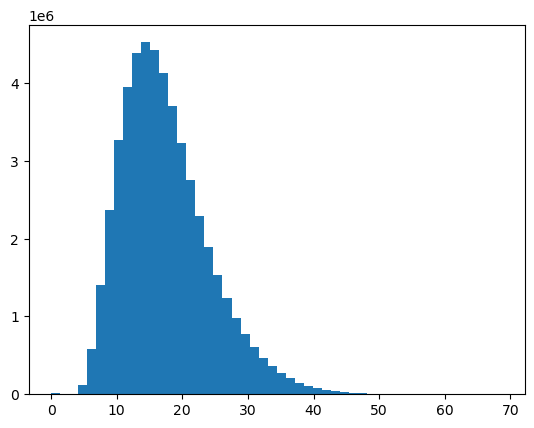

In [14]:
plt.hist(lower_triangular_flatten(detector.pca_projected_latents_dist[299]),bins=50)

In [25]:
unet.ood_detect_res

[(True, 400.17477843747423),
 (False, 21.131759429880628),
 (False, 7.82449742687177),
 (False, 7.409350568706502),
 (False, 6.882330611452917),
 (False, 5.184586713019941),
 (False, 5.428748499845044),
 (False, 5.5041651189814695),
 (False, 6.67506858151449),
 (True, 455.53995538732255),
 (True, 46.76654556824617),
 (False, 9.771233002299248),
 (False, 7.475158588677908),
 (False, 9.11033713054489),
 (False, 7.045249372288053),
 (False, 4.080901625321487),
 (False, 5.641608272234754),
 (False, 5.714259885450477),
 (True, 444.961639117715),
 (False, 34.63955961964576),
 (False, 7.038792838922032),
 (False, 6.944840051565659),
 (False, 6.4051130680443285),
 (False, 5.7472703960886315),
 (False, 4.491089974336974),
 (False, 6.26958582936495),
 (False, 7.137856860414232),
 (True, 444.39661093577234),
 (False, 30.926597054062032),
 (False, 7.630852528007893),
 (False, 6.114142646274612),
 (False, 5.792268467356089),
 (False, 3.9517979124147367),
 (False, 3.2108400495731515),
 (False, 10.48

In [24]:
unet.ood_detector

In [37]:
detector.pca_models[0].transform(np.random.randn(1,512))

array([[ 2.54550104e+00,  3.10309491e+00,  5.49073621e+00,
        -3.00501180e+00,  1.51051969e+01, -9.23123768e+00,
        -1.38781300e+00, -2.53154119e+00, -1.84989263e+00,
        -1.55675553e+00, -3.04200642e+00,  2.52645304e+00,
        -3.83899937e+00,  9.92622907e-01, -1.18826225e+00,
        -2.24639926e+00, -4.09735724e+00,  3.62514729e+00,
        -2.00815422e+00,  4.88361654e+00, -1.63710690e+00,
         4.06068784e+00, -5.14470815e-01, -2.94875203e+00,
        -3.21480841e-01,  6.30110329e-01,  2.99288276e+00,
        -2.30807668e-02, -4.49164755e-01,  6.51009583e-01,
         1.32693704e+00,  1.59697496e+00,  1.50705225e+00,
         7.60530159e-01,  1.90679181e+00, -1.17436952e+00,
         2.15413106e+00,  1.40545650e+00,  1.34069096e+00,
        -9.09895714e-02, -1.15236646e+00, -1.13937913e+00,
        -5.05328859e-01, -6.70381270e-01, -1.31738062e+00,
         4.24953584e-01,  9.47372790e-01, -4.02174355e-01,
         9.98556207e-01, -1.21572921e+00,  1.95336582e+0

/tmp/ipykernel_915175/1874284405.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots()


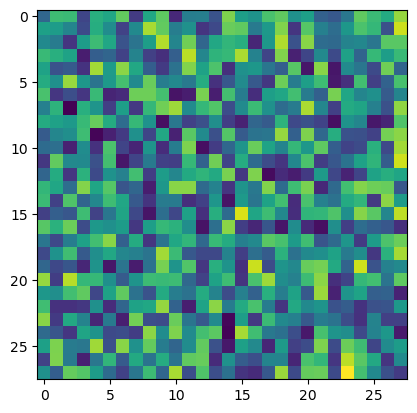

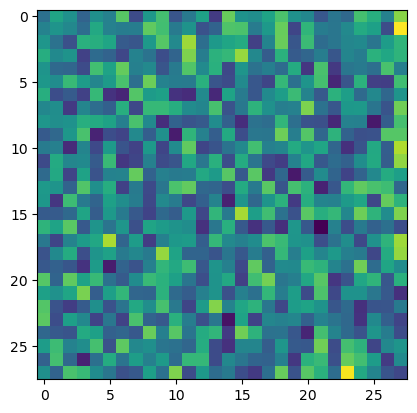

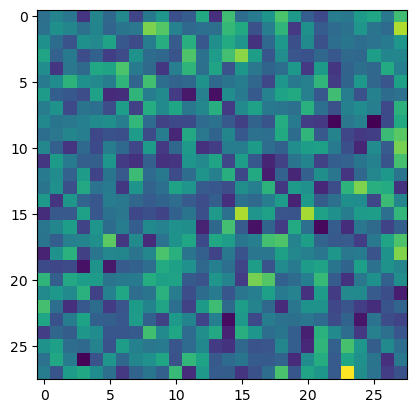

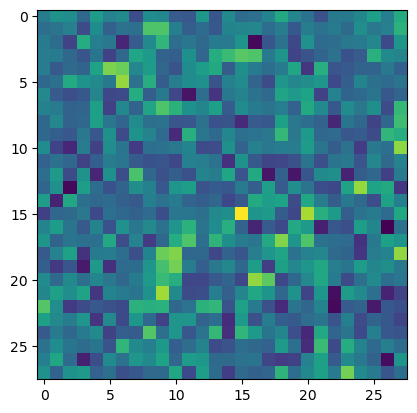

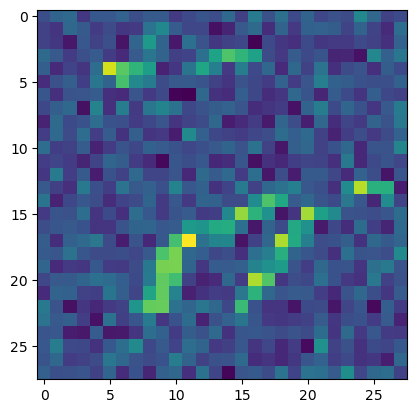

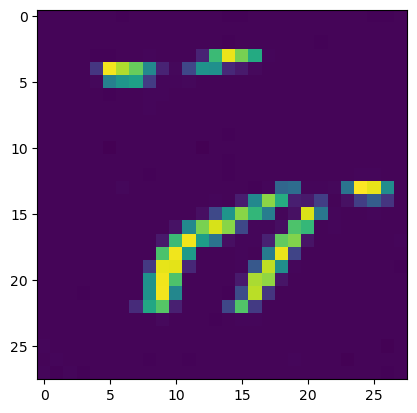

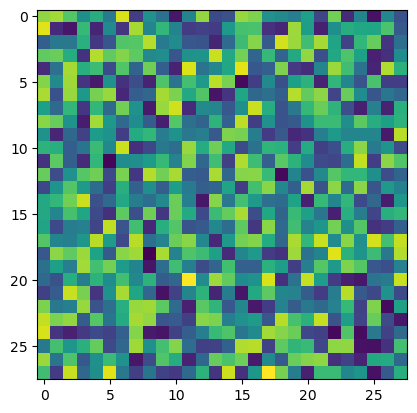

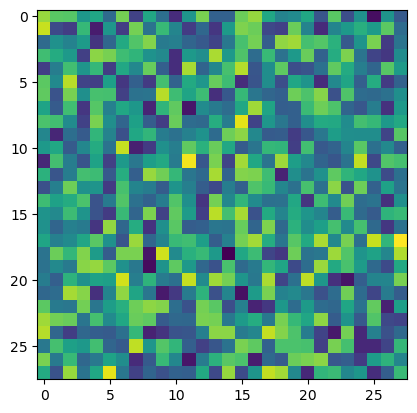

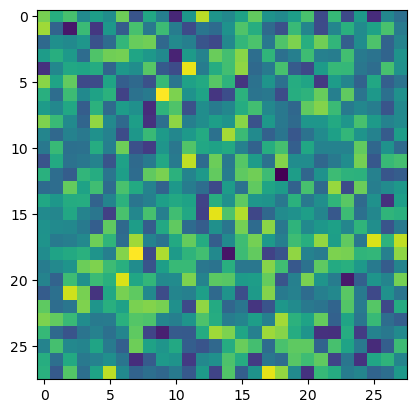

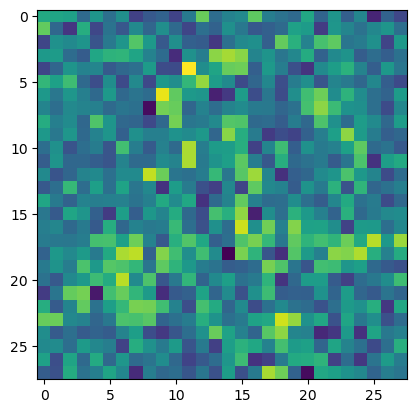

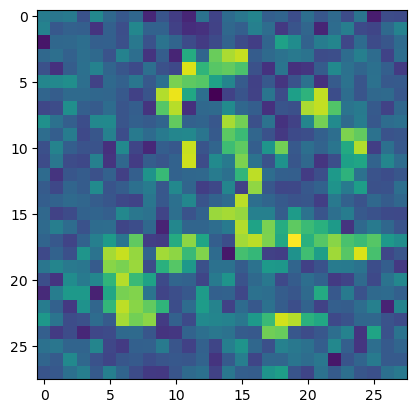

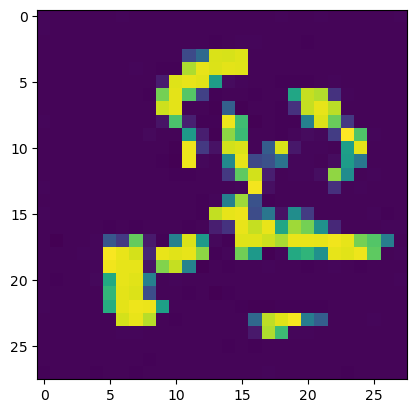

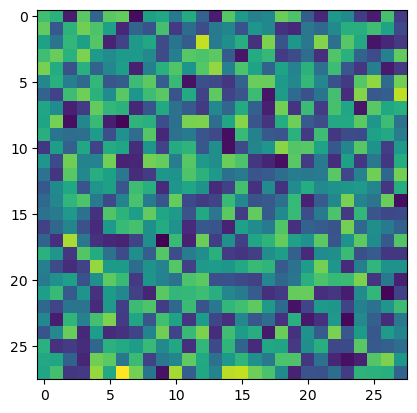

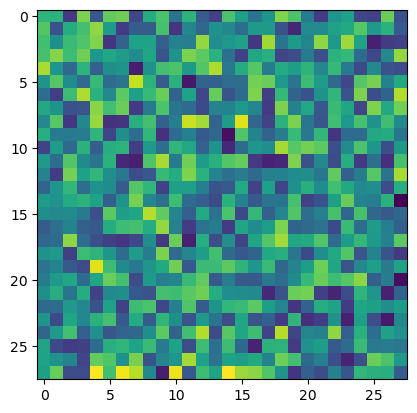

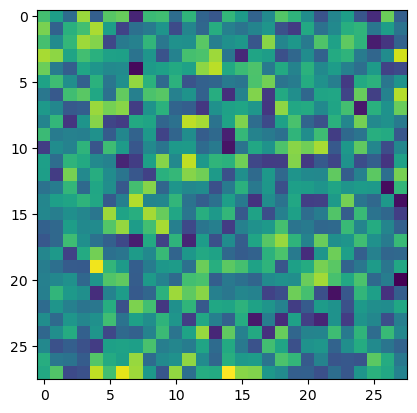

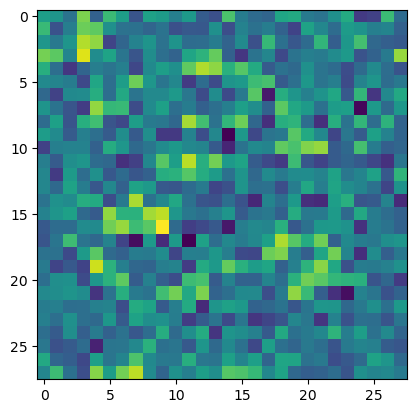

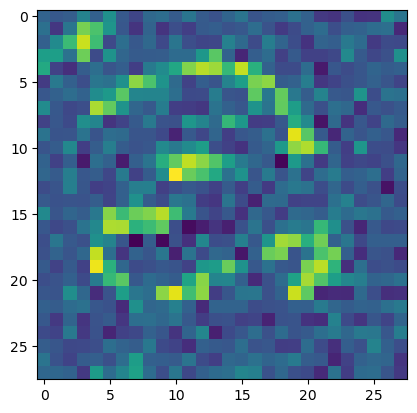

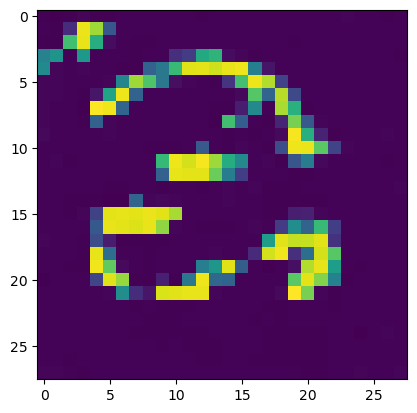

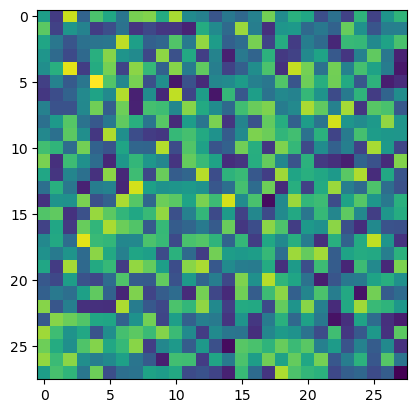

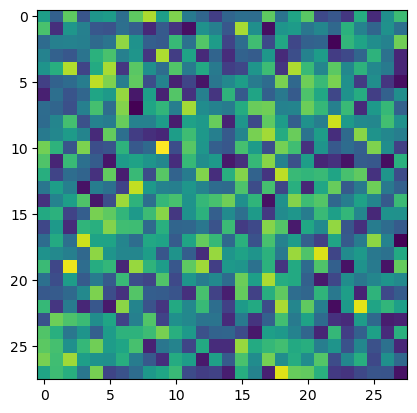

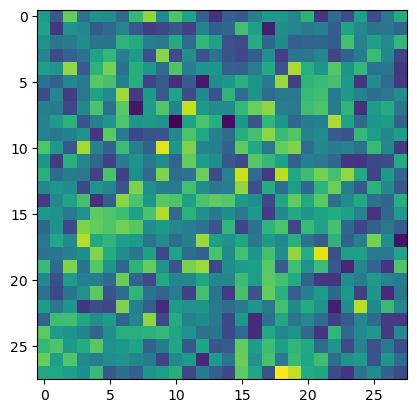

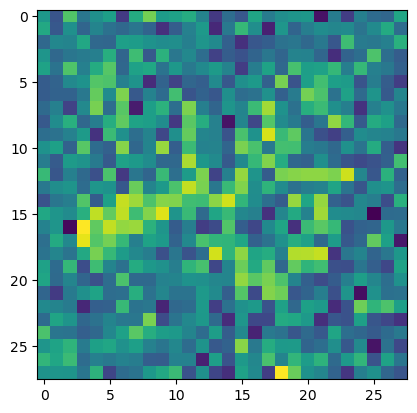

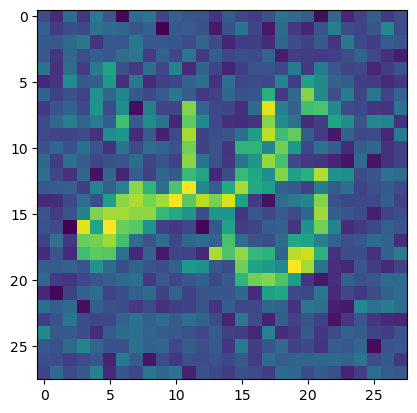

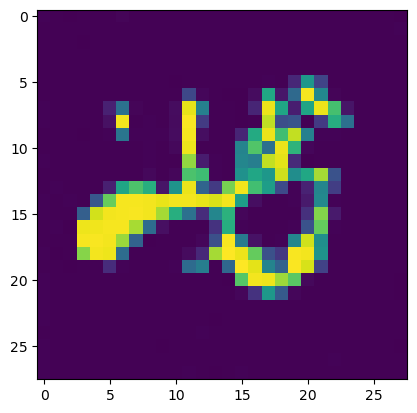

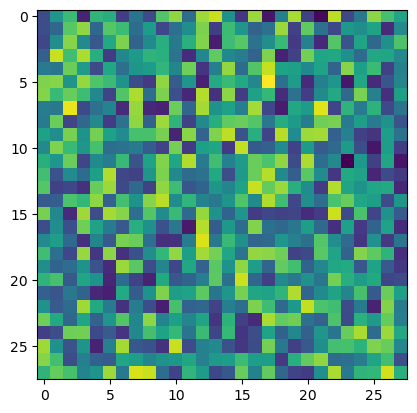

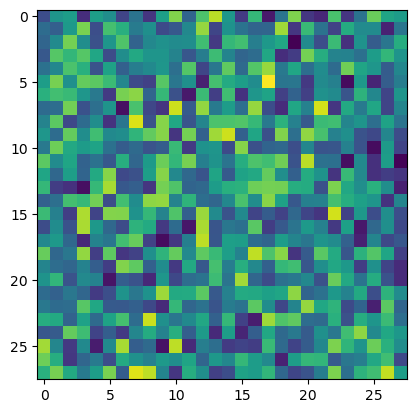

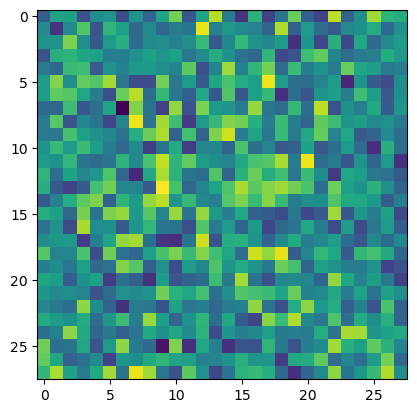

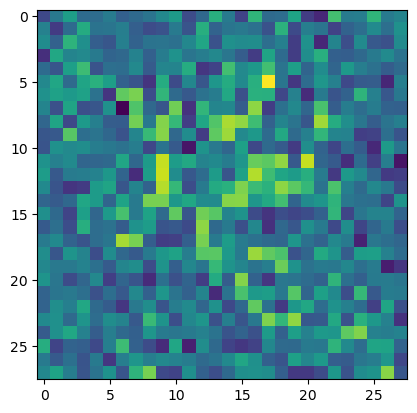

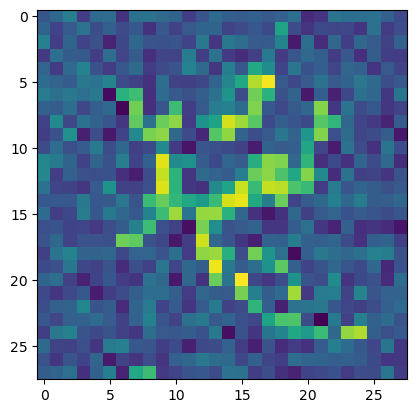

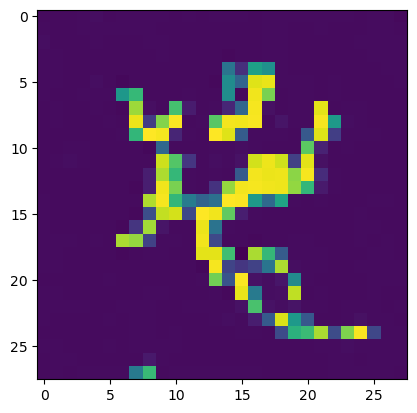

In [26]:
for img in infer_samples:
    for i in img:
        fig,ax = plt.subplots()
        ax.imshow(i[0][0])